<a href="https://colab.research.google.com/github/mlr-pravallika/email-spam-classification/blob/main/Copy_of_Email_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Important Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Load the Data**

In [4]:
df = pd.read_csv('/content/spam.csv',encoding = 'latin1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.rename(columns={'v1': 'target', 'v2':'text'}, inplace = True)

In [10]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
#label encoder

In [12]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [13]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df.isnull().sum()

,0
target,0
text,0


In [15]:
df.duplicated().sum()

np.int64(403)

In [16]:
df = df.drop_duplicates(keep='first')

In [17]:
df.shape

(5169, 2)

Percentage Of Ham and **Spam**

In [18]:
values = df['target'].value_counts()
total = values.sum()

percent_0 = (values[0]/total)*100
percent_1 = (values[1]/total)*100

print('% of 0: ', percent_0)
print('% of 1: ', percent_1)

% of 0:  87.3669955503966
% of 1:  12.633004449603405


TEXT LENGTH AND STRUCTURE **ANALYSIS**

In [19]:
nltk.download('punkt_tab')
df['num_characters']= df['text'].apply(len)
df['num_words']= df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentence']= df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

df[['num_characters', 'num_words', 'num_sentence']].describe()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,num_characters,num_words,num_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [20]:
#ham (non spam)

In [21]:
df[df['target']==0][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [22]:
df[df['target']==1][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


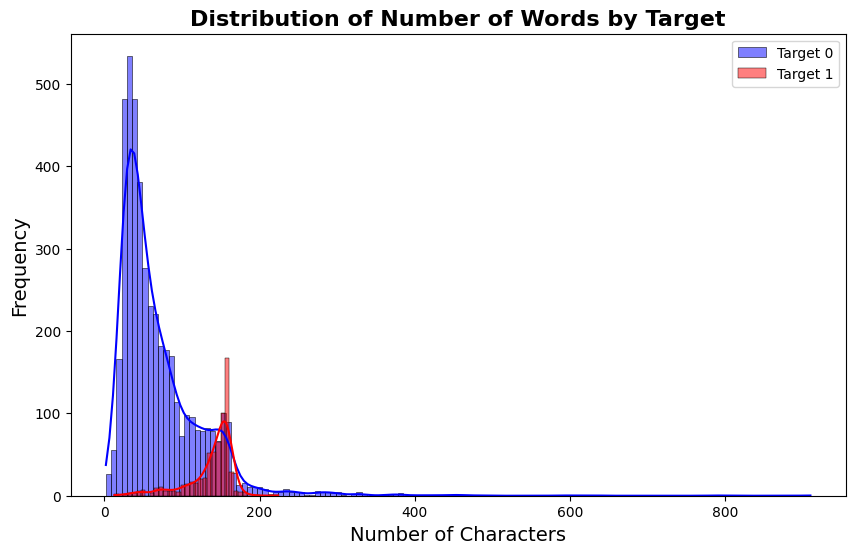

In [23]:
#character length distribution


import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df[df['target']==0]['num_characters'], color='blue', label='Target 0', kde = True)
sns.histplot(df[df['target']==1]['num_characters'], color='red', label='Target 1', kde = True)


plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Words by Target', fontsize=16, fontweight='bold')
plt.legend()
sns.set(style='whitegrid')
plt.show()

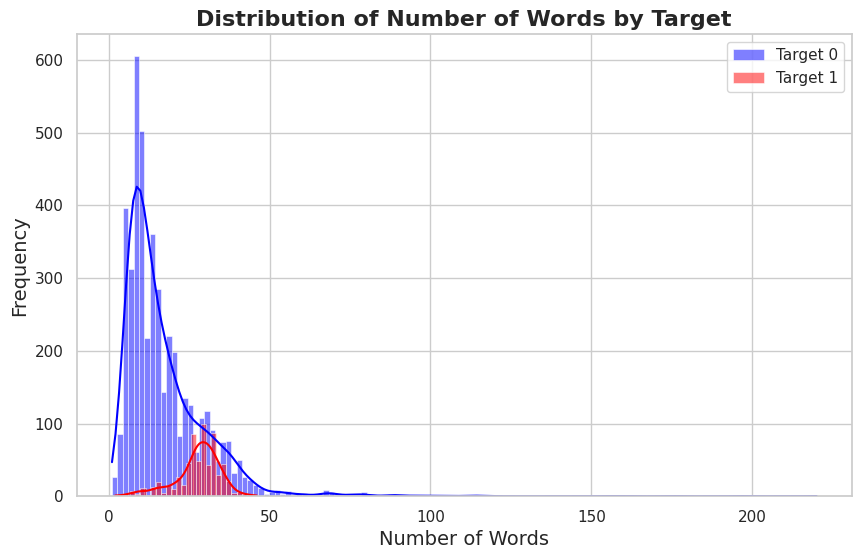

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['target']==0]['num_words'], color='blue', label='Target 0', kde = True)
sns.histplot(df[df['target']==1]['num_words'], color='red', label='Target 1', kde = True)


plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Words by Target', fontsize=16, fontweight='bold')
plt.legend()
sns.set(style='whitegrid')
plt.show()

In [ ]:
#pairplot

sns.set(style='ticks', color_codes= True)
g = sns.pairplot(df, hue='target', diag_kind='kde', markers=['o', 's'])

g.fig.suptitle("Pairplot of Data by Target", fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.95)
g._legend.set_title("Target")
for t, l in zip(g._legend.texts, ["Target 0", "Target 1"]):
  t.set_text(1)


plt.show()

In [ ]:
#Correlation Matrix

correlation_matrix = df[['target', 'num_characters', 'num_words', 'num_sentence']].corr()
plt.figure(figsize=(14, 6))
sns.set(font_scale = 1.2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt = '.2f')
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')

plt.xticks(rotation=45)

plt.show()


DATA **PREPROCESSING**

In [ ]:
from nltk.stem.porter import PorterStemmer

import string
ps = PorterStemmer()

def transform_text(text):
  text = text.lower()
  text = nltk.word_tokenize(text)


  y = []
  for i in text:
    if i.isalnum():
      y.append(i)
  text = y[:]
  y.clear()

  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      y.append(i)

  text=y[:]
  y.clear()
  for i in text:
    y.append(ps.stem(i))

  return " ".join(y)


In [ ]:
transform_text('Go around until jurong point, crazy.....Available only bring bringing bought buy in bugis n great')

In [ ]:
df['transformed_text'] = df['text'].apply(transform_text)

In [ ]:
#Find top 30 words of spam and not spam
spam_carpos = []
for sentence in df[df['target'] == 1]['transformed_text'].tolist():
  for word in sentence.split():
    spam_carpos.append(word)
from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(30))
sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')
plt.xticks(rotation = 90)
plt.show()

ham_carpos = []
for sentence in df[df['target'] == 0]['transformed_text'].tolist():
  for word in sentence.split():
    ham_carpos.append(word) # Corrected: appended to ham_carpos
from collections import Counter
filter_ham_df = pd.DataFrame(Counter(ham_carpos).most_common(30))
sns.barplot(data = filter_ham_df, x = filter_ham_df[0], y = filter_ham_df[1], palette = 'cool')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=300)

X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [ ]:
print(X_test.shape)
print(y_test.shape)

Import The **Models**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

Initialize the **Models**

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators = 50, random_state = 2)
abc = AdaBoostClassifier(n_estimators = 50, random_state = 2)
bc = BaggingClassifier(n_estimators = 50, random_state = 2)
etc = ExtraTreesClassifier(n_estimators = 50, random_state = 2)
gbdt = GradientBoostingClassifier(n_estimators = 50, random_state = 2)
xgb = XGBClassifier(n_estimators = 50, random_state = 2)

In [ ]:
#Creating a dictionary of models

clfs = {
    'SVC': svc,
    'KNN': knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT': gbdt,
    'xgb': xgb
}

In [ ]:
# train and fit the model

from sklearn.metrics import accuracy_score, precision_score
def train_classifier(clf,X_train,y_train,X_test,y_test):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  precision = precision_score(y_test,y_pred)
  return accuracy,precision

In [ ]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
  current_accuracy,current_precision = train_classifier(clf,X_train,y_train,X_test,y_test)
  print()
  print("For ",name)
  print("Accuracy is ",current_accuracy)
  print("Precision is ",current_precision)

  accuracy_scores.append(current_accuracy)
  precision_scores.append(current_precision)